## Selective Classification Can Magnify Disparities Across Groups


### AM207: Advanced Scientific Computing

#### Team: Jamelle Watson-Daniels, Shirley Wang, Bridger Ruyle, Paul Tembo

#### Paper: https://arxiv.org/pdf/2010.14134.pdfODOS: 

Minimal goal: Investigate how selective classification affects group accuracy on a synthetic `mnist` dataset
- Generate synthetic dataset from `mnist`
- Train empirical risk minimization model (minimize loss - Logistic regression i.e. ResNet)    
- Calculate average coverage
- Calculate group coverage
- Calculate selective accuracy
- Plot average coverage vs group coverage for `mnist` dataset
- Plot average coverage vs selective accuracy for `mnist` dataset

If there is time goal: Show that selective accuracies on average and on the worst-group are determined by their respective margin distributions
- Calculate margin
- Calculate worst-group density
- Calculate Average density
- Plot margin (-10,+10) versus worst-group density
- Plot margin (-10,+10) versus Average density

Possible extensions: What are the characteristics of this dataset that are imbalanced and contain spurious correlations? We see that in all these datasets, the "worst group" is underrepresented as in there are much fewer examples for the "worst group" category. Notice that the datasets considered in this paper do not seem immediately relevant in terms of the real world implications of disparities, we wonder how we might examine this using toy examples.

#### Dataset description
"Models have been shown to latch onto spurious correlations between labels and demographic attributes such as race and gender (Buolamwini & Gebru, 2018; Joshi et al., 2018), and we
study this on the CelebA dataset (Liu et al., 2015). Following Sagawa et al. (2020), we consider
the task of classifying hair color, which is spuriously correlated with the gender. Concretely, inputs
are celebrity face images, labels are hair color Y = {blond, non-blond}, and spurious attributes are
gender, A = {male, female}, with blondness associated with being female. Of the four groups,
blond males are the smallest group, with only 1,387 examples out of 162,770 training examples, and
they tend to be the worst group empirically. We use the official train-val-split of the dataset."

## Generate synthetic data 

Take the `mnist` dataset and consider the task of classifying digits 1 vs. 7. Alter the data such that the digit 1 is spuriously correlated with grey dots on the upper lefthand corner of the image. 

Concretely, inputs are `mnist` digits, labels are digit number Y = {1, 7}, and suprious attributes are grey boxes, A = {present, absent}, with added grey boxes associated with digit 7. Of the four groups, digit 1 with grey boxes are the smallest group. To mimic the `celebA` dataset in the original paper, we will alter the images such that approximately 8.5% of the training examples are digit 1 with grey boxes. 

In [ ]:
from autograd import grad
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import os
from sklearn.datasets import fetch_openml
from sklearn.utils import check_random_state
from sklearn.model_selection import train_test_split

In [ ]:
# Load data from https://www.openml.org/d/554
X, y = fetch_openml('mnist_784', version = 1, return_X_y = True, as_frame = False)

In [ ]:
# Pick out two classes of digits: 1, 7 and take a subset of samples 
X_subset = X[((y == '1') | (y == '7'))]
y_subset = y[((y == '1') | (y == '7'))]

# Encode the label '1' with y = 1, and the label '7' with y = 0
y_subset[y_subset == '1'] = 1
y_subset[y_subset == '7'] = 0
y_subset = y_subset.astype(int)

In [ ]:
# Split into training and testing sets
# Following celebA: 80% training, 10% val, 10% test 

rand_seed = 123
X_train, X_test_tot, y_train, y_test_tot = train_test_split(X_subset, y_subset, test_size = 0.2, random_state = rand_seed) # split out train
X_val, X_test, y_val, y_test = train_test_split(X_test_tot, y_test_tot, test_size = 0.5, random_state = rand_seed) # split out validation set 

In [ ]:
# save y_train, y_val, y_test labels in data folder

np.savetxt('data/y_train.csv', y_train, delimiter = ',')
np.savetxt('data/y_val.csv', y_val, delimiter = ',')
np.savetxt('data/y_test.csv', y_test, delimiter = ',')

In [ ]:
os.getcwd()

'/content'

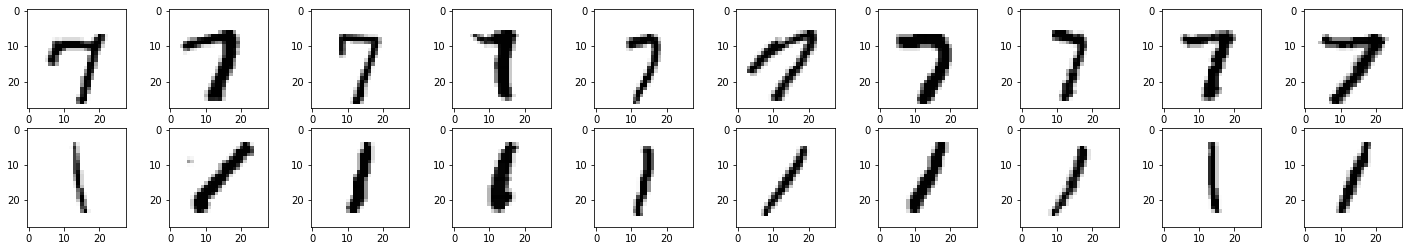

In [ ]:
# Visualize some samples from the training dataset 
fig, ax = plt.subplots(2, 10, figsize = (25, 4))
for i in range(10):
    ax[0, i].imshow(X_train[y_train == 0][i].reshape((28, 28)), cmap = plt.cm.gray_r, interpolation = 'nearest')
    ax[1, i].imshow(X_train[y_train == 1][i].reshape((28, 28)), cmap = plt.cm.gray_r, interpolation = 'nearest')

In [ ]:
# function to add a grey rectangular box to top left-hand corner of digit

def add_spurious_ft(x_array, y_array, perc_spurious_1, perc_spurious_2):
    '''
    this function takes in x and y arrays, adds spurious features to some images, and returns 
    the altered image array, along with indices of the images that were altered. spurious features
    include a grey box on the upper lefthand side of the image.
    
    x_array: array of shape (n_images, 784)
    y_array: array of shape (n_images, )
    perc_spurious_1: percent of digit 1 images to add spurious features to
    perc_spurious_2: percent of digit 1 images to add spurious features to

    returns: 
        altered image array
        indices of altered images (0 = not altered, 1 = altered)
    '''
    
    indices_1 = np.asarray(np.where(y_train == 1)).reshape(-1) # indices where digit = 1 
    indices_2 = np.asarray(np.where(y_train == 0)).reshape(-1) # indices where digit = 2 
    
    num_digit_1 = len(indices_1) # number of digit 1 images 
    num_digit_2 = len(indices_2) # number of digit 2 images 

    num_alter_1 = int(perc_spurious_1 * num_digit_1) # number of digit 1 images to alter
    num_alter_2 = int(perc_spurious_2 * num_digit_2) # number of digit 2 images to alter
    
    np.random.seed(123)
    rand_indices_1 = np.random.choice(len(indices_1), size = num_alter_1, replace = False) 
    rand_indices_2 = np.random.choice(len(indices_2), size = num_alter_2, replace = False) 
    
    grey_boxes = np.r_[0:15, 28:43, 56:71]
    altered_imgs = x_array
    
    image_altered = []
    
    for i in range(len(altered_imgs)):
        
        # alter digit 2 images 
        if y_train[i] == 0:
            if i in rand_indices_2:
                altered_imgs[i][grey_boxes] = np.array([256] * len(grey_boxes))
                image_altered.append(1) # 1 = altered 
            else:
                image_altered.append(0) # 0 = not altered
        
        # alter digit 1 images 
        elif y_train[i] == 1:
            if i in rand_indices_1:
                altered_imgs[i][grey_boxes] = np.array([256] * len(grey_boxes))
                image_altered.append(1)
            else: 
                image_altered.append(0)
    
    return altered_imgs, np.array(image_altered)

In [ ]:
# test to see if the function works 
test_altered_imgs, test_altered_indices = add_spurious_ft(X_train, y_train, 0.085, 0.7)

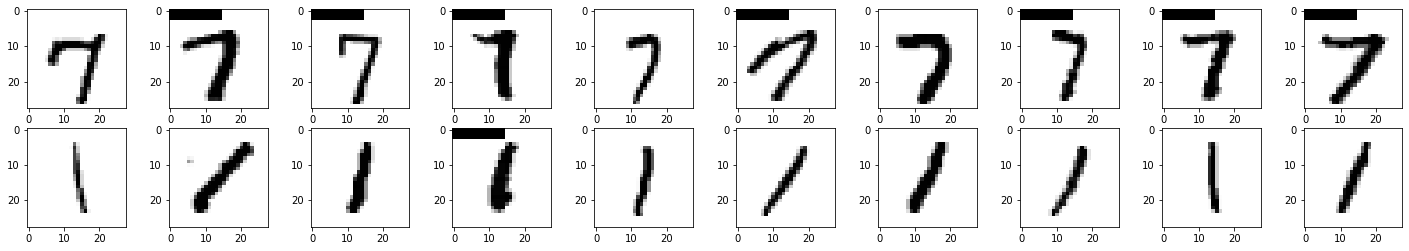

In [ ]:
# Visualize some samples from the altered training dataset. more 2's with spurious features than 1's. seems to work! 
fig, ax = plt.subplots(2, 10, figsize = (25, 4))
for i in range(10):
    ax[0, i].imshow(test_altered_imgs[y_train == 0][i].reshape((28, 28)), cmap = plt.cm.gray_r, interpolation = 'nearest')
    ax[1, i].imshow(test_altered_imgs[y_train == 1][i].reshape((28, 28)), cmap = plt.cm.gray_r, interpolation = 'nearest')

## Generate 4 Sets of Image Datasets (Train, Val, Test): 

`X_train_9`, `X_val_9`, `X_test_9`: 90% spurious features in digit 2; 8.5% spurious features in digit 1.

`X_train_7`, `X_val_7`, `X_test_7`: 70% spurious features in digit 2; 8.5% spurious features in digit 1.

`X_train_5`, `X_val_5`, `X_test_5`: 50% spurious features in digit 2; 8.5% spurious features in digit 1.

`X_train_3`, `X_val_3`, `X_test_3`: 30% spurious features in digit 2; 8.5% spurious features in digit 1.

In [ ]:
# 90% spurious in digit 7 
X_train_9, X_train_9_altindices = add_spurious_ft(X_train, y_train, 0.085, 0.9)
X_val_9, X_val_9_altindices = add_spurious_ft(X_val, y_val, 0.085, 0.9)
X_test_9, X_test_9_altindices = add_spurious_ft(X_test, y_test, 0.085, 0.9)

# 70% spurious in digit 7 
X_train_7, X_train_7_altindices = add_spurious_ft(X_train, y_train, 0.085, 0.7)
X_val_7, X_val_7_altindices = add_spurious_ft(X_val, y_val, 0.085, 0.7)
X_test_7, X_test_7_altindices = add_spurious_ft(X_test, y_test, 0.085, 0.7)

# 50% spurious in digit 7
X_train_5, X_train_5_altindices = add_spurious_ft(X_train, y_train, 0.085, 0.5)
X_val_5, X_val_5_altindices = add_spurious_ft(X_val, y_val, 0.085, 0.5)
X_test_5, X_test_5_altindices = add_spurious_ft(X_test, y_test, 0.085, 0.5)

# 30% spurious in digit7
X_train_3, X_train_3_altindices = add_spurious_ft(X_train, y_train, 0.085, 0.3)
X_val_3, X_val_3_altindices = add_spurious_ft(X_val, y_val, 0.085, 0.3)
X_test_3, X_test_3_altindices = add_spurious_ft(X_test, y_test, 0.085, 0.3)

In [ ]:
# save altered indices labels 

np.savetxt('data/altered_index_train_9.csv', X_train_9_altindices, delimiter = ',')
np.savetxt('data/altered_index_val_9.csv', X_val_9_altindices, delimiter = ',')
np.savetxt('data/altered_index_test_9.csv', X_test_9_altindices, delimiter = ',')

np.savetxt('data/altered_index_train_7.csv', X_train_7_altindices, delimiter = ',')
np.savetxt('data/altered_index_val_7.csv', X_val_7_altindices, delimiter = ',')
np.savetxt('data/altered_index_test_7.csv', X_test_7_altindices, delimiter = ',')

np.savetxt('data/altered_index_train_5.csv', X_train_5_altindices, delimiter = ',')
np.savetxt('data/altered_index_val_5.csv', X_val_5_altindices, delimiter = ',')
np.savetxt('data/altered_index_test_5.csv', X_test_5_altindices, delimiter = ',')

np.savetxt('data/altered_index_train_3.csv', X_train_3_altindices, delimiter = ',')
np.savetxt('data/altered_index_val_3.csv', X_val_3_altindices, delimiter = ',')
np.savetxt('data/altered_index_test_3.csv', X_test_3_altindices, delimiter = ',')

In [ ]:
# try to save x_arrays 

np.savetxt('data/x_array/X_train_9.csv', X_train_9, delimiter = ',')
np.savetxt('data/x_array/X_val_9.csv', X_val_9, delimiter = ',')
np.savetxt('data/x_array/X_test_9.csv', X_test_9, delimiter = ',')

np.savetxt('data/x_array/X_train_7.csv', X_train_7, delimiter = ',')
np.savetxt('data/x_array/X_val_7.csv', X_val_7, delimiter = ',')
np.savetxt('data/x_array/X_test_7.csv', X_test_7, delimiter = ',')

np.savetxt('data/x_array/X_train_5.csv', X_train_5, delimiter = ',')
np.savetxt('data/x_array/X_val_5.csv', X_val_5, delimiter = ',')
np.savetxt('data/x_array/X_test_5.csv', X_test_5, delimiter = ',')

np.savetxt('data/x_array/X_train_3.csv', X_train_3, delimiter = ',')
np.savetxt('data/x_array/X_val_3.csv', X_val_3, delimiter = ',')
np.savetxt('data/x_array/X_test_3.csv', X_test_3, delimiter = ',')

# Pauls Part

In [ ]:
# 90% spurious in digit 2 reshaped

X_train_9_reshaped = X_train_9.reshape((X_train_9.shape[0], 28, 28))
X_val_9_reshaped = X_val_9.reshape((X_val_9.shape[0], 28, 28))
X_test_9_reshaped = X_test_9.reshape((X_test_9.shape[0], 28, 28))

# # 70% spurious in digit 2 reshaped
X_train_7_reshaped = X_train_7.reshape((X_train_7.shape[0], 28, 28))
X_val_7_reshaped = X_val_7.reshape((X_val_7.shape[0], 28, 28))
X_test_7_reshaped = X_test_7.reshape((X_test_7.shape[0], 28, 28))


# # 50% spurious in digit 2 reshaped

X_train_5_reshaped = X_train_5.reshape((X_train_5.shape[0], 28, 28))
X_val_5_reshaped = X_val_5.reshape((X_val_5.shape[0], 28, 28))
X_test_5_reshaped = X_test_5.reshape((X_test_5.shape[0], 28, 28))


# # 30% spurious in digit 2 reshaped


X_train_3_reshaped = X_train_3.reshape((X_train_3.shape[0], 28, 28))
X_val_3_reshaped = X_val_3.reshape((X_val_3.shape[0], 28, 28))
X_test_3_reshaped = X_test_3.reshape((X_test_3.shape[0], 28, 28))


print(X_train_9_reshaped.shape)
print(X_val_9_reshaped.shape)
print(X_test_9_reshaped.shape)
# print(X_train_7_reshaped.shape)
# print(X_val_7_reshaped.shape)
# print(X_test_7_reshaped.shape)
# print(X_train_5_reshaped.shape)
# print(X_val_5_reshaped.shape)
# print(X_test_5_reshaped.shape)
# print(X_train_3_reshaped.shape)
# print(X_val_3_reshaped.shape)
# print(X_test_3_reshaped.shape)

(12136, 28, 28)
(1517, 28, 28)
(1517, 28, 28)


In [ ]:
print(X_train_9_reshaped.shape)
print(y_train.shape)
print(X_test_9_reshaped.shape)
print(y_test.shape)
# expand new axis, channel axis 
x_train_x9 = np.expand_dims(X_train_9_reshaped, axis=-1)
x_test_x9 = np.expand_dims(X_test_9_reshaped, axis=-1)
x_val_x9 = np.expand_dims(X_val_9_reshaped, axis=-1)
x_train_x7 = np.expand_dims(X_train_7_reshaped, axis=-1)
x_test_x7 = np.expand_dims(X_test_7_reshaped, axis=-1)

x_val_x7 = np.expand_dims(X_val_7_reshaped, axis=-1)

x_train_x5 = np.expand_dims(X_train_5_reshaped, axis=-1)
x_test_x5 = np.expand_dims(X_test_5_reshaped, axis=-1)

x_val_x5 = np.expand_dims(X_val_5_reshaped, axis=-1)

x_train_x3 = np.expand_dims(X_train_3_reshaped, axis=-1)
x_test_x3 = np.expand_dims(X_test_3_reshaped, axis=-1)

x_val_x3 = np.expand_dims(X_val_3_reshaped, axis=-1)

# We need 3 channel (instead of 1)
x_train_x9 = np.repeat(x_train_x9, 3, axis=-1)
x_test_x9 = np.repeat(x_test_x9, 3, axis=-1)
x_val_x9 = np.repeat(x_val_x9, 3, axis=-1)

x_train_x7 = np.repeat(x_train_x7, 3, axis=-1)
x_test_x7 = np.repeat(x_test_x7, 3, axis=-1)

x_val_x7 = np.repeat(x_val_x7, 3, axis=-1)

x_train_x5 = np.repeat(x_train_x5, 3, axis=-1)
x_test_x5 = np.repeat(x_test_x5, 3, axis=-1)

x_val_x5 = np.repeat(x_val_x5, 3, axis=-1)

x_train_x3 = np.repeat(x_train_x3, 3, axis=-1)
x_test_x3 = np.repeat(x_test_x3, 3, axis=-1)
x_val_x3 = np.repeat(x_val_x3, 3, axis=-1)

# normalize 
x_train_x9 = x_train_x9.astype('float32') / 255
x_test_x9 = x_test_x9.astype('float32') / 255
x_val_x9 = x_val_x9.astype('float32') / 255

x_train_x7 = x_train_x7.astype('float32') / 255
x_test_x7 = x_test_x7.astype('float32') / 255
x_val_x7 = x_val_x7.astype('float32') / 255

x_train_x5 = x_train_x5.astype('float32') / 255
x_test_x5 = x_test_x5.astype('float32') / 255
x_val_x5 = x_val_x5.astype('float32') / 255
x_train_x3 = x_train_x3.astype('float32') / 255
x_test_x3 = x_test_x3.astype('float32') / 255
x_val_x3 = x_val_x3.astype('float32') / 255

# resize the input shape , i.e. old shape: 28, new shape: 32
x_train_x9 = tf.image.resize(x_train_x9, [32,32]) # if we want to resize
x_test_x9 = tf.image.resize(x_test_x9, [32,32]) # if we want to resize 
x_val_x9 = tf.image.resize(x_val_x9, [32,32]) # if we want to resize 

x_train_x7 = tf.image.resize(x_train_x7, [32,32]) # if we want to resize
x_test_x7 = tf.image.resize(x_test_x7, [32,32]) # if we want to resize 
x_val_x7 = tf.image.resize(x_val_x7, [32,32]) # if we want to resize 

x_train_x5 = tf.image.resize(x_train_x5, [32,32]) # if we want to resize
x_test_x5 = tf.image.resize(x_test_x5, [32,32]) # if we want to resize 
x_val_x5 = tf.image.resize(x_val_x5, [32,32]) # if we want to resize 

x_train_x3 = tf.image.resize(x_train_x3, [32,32]) # if we want to resize
x_test_x3 = tf.image.resize(x_test_x3, [32,32]) # if we want to resize 
x_val_x3 = tf.image.resize(x_val_x3, [32,32]) # if we want to resize 

(12136, 28, 28)
(12136,)
(1517, 28, 28)
(1517,)


In [ ]:
inputs = tf.keras.Input(shape = (32, 32, 3))

# Load ResNet with preset weights from "imagenet" training
base_model_9 = tf.keras.applications.ResNet50(
    input_tensor = inputs,
    include_top = False,
    weights = 'imagenet'
)

base_model_9.traninable = False

94781440/94765736 [==============================] - 0s 0us/step


In [ ]:
# Add three layers at the end of ResNet:
    #A global average 2d pooling layer
    #A dropout layer
    #And a trainable binary classifier that predicts whether an celebrity has blond or non-blond hair
add_model = tf.keras.Sequential()
add_model.add(base_model_9)
add_model.add(tf.keras.layers.GlobalAveragePooling2D())
add_model.add(tf.keras.layers.Dropout(0.2))
add_model.add(tf.keras.layers.Dense(2, 
                    activation='softmax'))

model_9 = add_model
model_9.compile(loss='sparse_categorical_crossentropy', 
              optimizer='sgd',
              metrics=['accuracy'])

In [32]:
#base_model compile and fit model 9
history_9 = model_9.fit(x=x_train_x9,y=y_train, validation_data=(x_val_x9, y_val), epochs=10)

predict_9 = model_9.predict(x_test_x9)

np.savetxt('data/prediction/RESNET_predict_9.csv', predict_9, delimiter = ',')

Epoch 1/10
380/380 [==============================] - 13s 35ms/step - loss: 0.0019 - accuracy: 0.9997 - val_loss: 0.0148 - val_accuracy: 0.9967
Epoch 2/10
380/380 [==============================] - 13s 35ms/step - loss: 6.8497e-04 - accuracy: 0.9999 - val_loss: 0.0285 - val_accuracy: 0.9927
Epoch 3/10
380/380 [==============================] - 13s 35ms/step - loss: 0.0016 - accuracy: 0.9996 - val_loss: 0.0132 - val_accuracy: 0.9974
Epoch 4/10
380/380 [==============================] - 13s 35ms/step - loss: 4.7733e-04 - accuracy: 0.9998 - val_loss: 0.0160 - val_accuracy: 0.9980
Epoch 5/10
380/380 [==============================] - 13s 35ms/step - loss: 1.7498e-04 - accuracy: 0.9999 - val_loss: 0.0148 - val_accuracy: 0.9980
Epoch 6/10
380/380 [==============================] - 13s 35ms/step - loss: 1.3306e-04 - accuracy: 1.0000 - val_loss: 0.0162 - val_accuracy: 0.9980
Epoch 7/10
380/380 [==============================] - 13s 35ms/step - loss: 3.0857e-04 - accuracy: 0.9999 - val_loss: 0.

In [33]:
inputs = tf.keras.Input(shape = (32, 32, 3))

# Load ResNet with preset weights from "imagenet" training
base_model_7 = tf.keras.applications.ResNet50(
    input_tensor = inputs,
    include_top = False,
    weights = 'imagenet'
)

base_model_7.traninable = False

In [34]:
# Add three layers at the end of ResNet:
    #A global average 2d pooling layer
    #A dropout layer
    #And a trainable binary classifier that predicts whether an celebrity has blond or non-blond hair
add_model = tf.keras.Sequential()
add_model.add(base_model_7)
add_model.add(tf.keras.layers.GlobalAveragePooling2D())
add_model.add(tf.keras.layers.Dropout(0.2))
add_model.add(tf.keras.layers.Dense(2, 
                    activation='softmax'))

model_7 = add_model
model_7.compile(loss='sparse_categorical_crossentropy', 
              optimizer='sgd',
              metrics=['accuracy'])

In [35]:
#base_model compile and fit model 9
history_7 = model_7.fit(x=x_train_x7,y=y_train, validation_data=(x_val_x7, y_val), epochs=10)

predict_7 = model_7.predict(x_test_x7)

np.savetxt('data/prediction/RESNET_predict_7.csv', predict_7, delimiter = ',')

Epoch 1/10
380/380 [==============================] - 18s 37ms/step - loss: 0.0482 - accuracy: 0.9842 - val_loss: 1.1543 - val_accuracy: 0.5208
Epoch 2/10
380/380 [==============================] - 13s 35ms/step - loss: 0.0130 - accuracy: 0.9964 - val_loss: 0.2306 - val_accuracy: 0.8787
Epoch 3/10
380/380 [==============================] - 13s 35ms/step - loss: 0.0096 - accuracy: 0.9971 - val_loss: 0.0180 - val_accuracy: 0.9954
Epoch 4/10
380/380 [==============================] - 13s 35ms/step - loss: 0.0061 - accuracy: 0.9986 - val_loss: 0.0416 - val_accuracy: 0.9875
Epoch 5/10
380/380 [==============================] - 13s 35ms/step - loss: 0.0111 - accuracy: 0.9962 - val_loss: 0.5261 - val_accuracy: 0.8688
Epoch 6/10
380/380 [==============================] - 13s 35ms/step - loss: 0.0074 - accuracy: 0.9977 - val_loss: 0.0116 - val_accuracy: 0.9960
Epoch 7/10
380/380 [==============================] - 13s 35ms/step - loss: 0.0035 - accuracy: 0.9985 - val_loss: 0.0140 - val_accuracy:

In [38]:
inputs = tf.keras.Input(shape = (32, 32, 3))

# Load ResNet with preset weights from "imagenet" training
base_model_5 = tf.keras.applications.ResNet50(
    input_tensor = inputs,
    include_top = False,
    weights = 'imagenet'
)

base_model_5.traninable = False

In [39]:
# Add three layers at the end of ResNet:
    #A global average 2d pooling layer
    #A dropout layer
    #And a trainable binary classifier that predicts whether an celebrity has blond or non-blond hair
add_model = tf.keras.Sequential()
add_model.add(base_model_5)
add_model.add(tf.keras.layers.GlobalAveragePooling2D())
add_model.add(tf.keras.layers.Dropout(0.2))
add_model.add(tf.keras.layers.Dense(2, 
                    activation='softmax'))

model_5 = add_model
model_5.compile(loss='sparse_categorical_crossentropy', 
              optimizer='sgd',
              metrics=['accuracy'])

In [40]:
#base_model compile and fit model 9
history_5 = model_5.fit(x=x_train_x5,y=y_train, validation_data=(x_val_x5, y_val), epochs=10)

predict_5 = model_7.predict(x_test_x5)

np.savetxt('data/prediction/RESNET_predict_5.csv', predict_5, delimiter = ',')

Epoch 1/10
380/380 [==============================] - 18s 37ms/step - loss: 0.0593 - accuracy: 0.9810 - val_loss: 0.6638 - val_accuracy: 0.5748
Epoch 2/10
380/380 [==============================] - 13s 35ms/step - loss: 0.0156 - accuracy: 0.9951 - val_loss: 0.4022 - val_accuracy: 0.8603
Epoch 3/10
380/380 [==============================] - 13s 34ms/step - loss: 0.0088 - accuracy: 0.9972 - val_loss: 0.0125 - val_accuracy: 0.9974
Epoch 4/10
380/380 [==============================] - 13s 34ms/step - loss: 0.0093 - accuracy: 0.9974 - val_loss: 0.0107 - val_accuracy: 0.9980
Epoch 5/10
380/380 [==============================] - 13s 34ms/step - loss: 0.0049 - accuracy: 0.9985 - val_loss: 0.0117 - val_accuracy: 0.9980
Epoch 6/10
380/380 [==============================] - 13s 35ms/step - loss: 0.0037 - accuracy: 0.9988 - val_loss: 0.0125 - val_accuracy: 0.9980
Epoch 7/10
380/380 [==============================] - 13s 35ms/step - loss: 0.0027 - accuracy: 0.9989 - val_loss: 0.0155 - val_accuracy:

In [41]:
inputs = tf.keras.Input(shape = (32, 32, 3))

# Load ResNet with preset weights from "imagenet" training
base_model_3 = tf.keras.applications.ResNet50(
    input_tensor = inputs,
    include_top = False,
    weights = 'imagenet'
)

base_model_3.traninable = False

In [42]:
# Add three layers at the end of ResNet:
    #A global average 2d pooling layer
    #A dropout layer
    #And a trainable binary classifier that predicts whether an celebrity has blond or non-blond hair
add_model = tf.keras.Sequential()
add_model.add(base_model_3)
add_model.add(tf.keras.layers.GlobalAveragePooling2D())
add_model.add(tf.keras.layers.Dropout(0.2))
add_model.add(tf.keras.layers.Dense(2, 
                    activation='softmax'))

model_3 = add_model
model_3.compile(loss='sparse_categorical_crossentropy', 
              optimizer='sgd',
              metrics=['accuracy'])

In [53]:
#base_model compile and fit model 9
history_3 = model_3.fit(x=x_train_x3,y=y_train, validation_data=(x_val_x3, y_val), epochs=10)

predict_3 = model_3.predict(x_test_x3)

np.savetxt('data/prediction/RESNET_predict_3.csv', predict_3, delimiter = ',')

Epoch 1/10
380/380 [==============================] - 13s 35ms/step - loss: 9.5549e-04 - accuracy: 0.9995 - val_loss: 0.0128 - val_accuracy: 0.9967
Epoch 2/10
380/380 [==============================] - 13s 35ms/step - loss: 6.6765e-04 - accuracy: 0.9998 - val_loss: 0.0139 - val_accuracy: 0.9967
Epoch 3/10
380/380 [==============================] - 13s 35ms/step - loss: 5.2242e-04 - accuracy: 0.9998 - val_loss: 0.0170 - val_accuracy: 0.9974
Epoch 4/10
380/380 [==============================] - 13s 35ms/step - loss: 3.2611e-04 - accuracy: 1.0000 - val_loss: 0.0146 - val_accuracy: 0.9980
Epoch 5/10
380/380 [==============================] - 13s 35ms/step - loss: 9.9016e-04 - accuracy: 0.9997 - val_loss: 0.0170 - val_accuracy: 0.9974
Epoch 6/10
380/380 [==============================] - 13s 34ms/step - loss: 9.3470e-04 - accuracy: 0.9998 - val_loss: 0.0145 - val_accuracy: 0.9974
Epoch 7/10
380/380 [==============================] - 13s 35ms/step - loss: 3.2023e-04 - accuracy: 0.9999 - val_

**Regular 2 layer NN**

In [56]:
reg_model_9 = tf.keras.models.Sequential([tf.keras.layers.Flatten(input_shape = (32,32,3)), 
                                    tf.keras.layers.Dense(128, activation=tf.nn.relu), 
                                    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)])

In [57]:
reg_model_9.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 3072)              0         
                                                                 
 dense_14 (Dense)            (None, 128)               393344    
                                                                 
 dense_15 (Dense)            (None, 1)                 129       
                                                                 
Total params: 393,473
Trainable params: 393,473
Non-trainable params: 0
_________________________________________________________________


In [58]:
reg_model_9.compile(optimizer ='sgd',
              loss = 'binary_crossentropy',
              metrics=['accuracy'])

# model 9 regular 2 layer rnn compile and fit
reg_model_9_history = reg_model_9.fit(x=x_train_x9,y=y_train, validation_data=(x_val_x9, y_val), epochs=10)


predict_nn_9 = reg_model_9.predict(x_test_x9)

np.savetxt('data/prediction/NN_predict_9.csv', predict_nn_9, delimiter = ',')

Epoch 1/10
380/380 [==============================] - 1s 3ms/step - loss: 0.0950 - accuracy: 0.9777 - val_loss: 0.0629 - val_accuracy: 0.9842
Epoch 2/10
380/380 [==============================] - 1s 2ms/step - loss: 0.0351 - accuracy: 0.9910 - val_loss: 0.0455 - val_accuracy: 0.9881
Epoch 3/10
380/380 [==============================] - 1s 2ms/step - loss: 0.0279 - accuracy: 0.9927 - val_loss: 0.0371 - val_accuracy: 0.9901
Epoch 4/10
380/380 [==============================] - 1s 3ms/step - loss: 0.0244 - accuracy: 0.9931 - val_loss: 0.0333 - val_accuracy: 0.9914
Epoch 5/10
380/380 [==============================] - 1s 3ms/step - loss: 0.0220 - accuracy: 0.9936 - val_loss: 0.0293 - val_accuracy: 0.9914
Epoch 6/10
380/380 [==============================] - 1s 3ms/step - loss: 0.0203 - accuracy: 0.9938 - val_loss: 0.0277 - val_accuracy: 0.9914
Epoch 7/10
380/380 [==============================] - 1s 3ms/step - loss: 0.0190 - accuracy: 0.9944 - val_loss: 0.0262 - val_accuracy: 0.9921
Epoch 

In [59]:
reg_model_7 = tf.keras.models.Sequential([tf.keras.layers.Flatten(input_shape = (32,32,3)), 
                                    tf.keras.layers.Dense(128, activation=tf.nn.relu), 
                                    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)])

In [60]:
reg_model_7.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 3072)              0         
                                                                 
 dense_16 (Dense)            (None, 128)               393344    
                                                                 
 dense_17 (Dense)            (None, 1)                 129       
                                                                 
Total params: 393,473
Trainable params: 393,473
Non-trainable params: 0
_________________________________________________________________


In [61]:
reg_model_7.compile(optimizer ='sgd',
              loss = 'binary_crossentropy',
              metrics=['accuracy'])

# model 7 regular 2 layer rnn compile and fit
reg_model_7_history = reg_model_7.fit(x=x_train_x7,y=y_train, validation_data=(x_val_x7, y_val), epochs=10)


predict_nn_7 = reg_model_7.predict(x_test_x7)

np.savetxt('data/prediction/NN_predict_7.csv', predict_nn_7, delimiter = ',')

Epoch 1/10
380/380 [==============================] - 2s 4ms/step - loss: 0.0929 - accuracy: 0.9768 - val_loss: 0.0590 - val_accuracy: 0.9855
Epoch 2/10
380/380 [==============================] - 1s 3ms/step - loss: 0.0349 - accuracy: 0.9907 - val_loss: 0.0417 - val_accuracy: 0.9881
Epoch 3/10
380/380 [==============================] - 1s 3ms/step - loss: 0.0279 - accuracy: 0.9917 - val_loss: 0.0350 - val_accuracy: 0.9881
Epoch 4/10
380/380 [==============================] - 1s 3ms/step - loss: 0.0244 - accuracy: 0.9931 - val_loss: 0.0319 - val_accuracy: 0.9895
Epoch 5/10
380/380 [==============================] - 1s 3ms/step - loss: 0.0219 - accuracy: 0.9939 - val_loss: 0.0287 - val_accuracy: 0.9914
Epoch 6/10
380/380 [==============================] - 1s 3ms/step - loss: 0.0202 - accuracy: 0.9940 - val_loss: 0.0290 - val_accuracy: 0.9927
Epoch 7/10
380/380 [==============================] - 1s 3ms/step - loss: 0.0190 - accuracy: 0.9946 - val_loss: 0.0244 - val_accuracy: 0.9927
Epoch 

In [62]:
reg_model_5 = tf.keras.models.Sequential([tf.keras.layers.Flatten(input_shape = (32,32,3)), 
                                    tf.keras.layers.Dense(128, activation=tf.nn.relu), 
                                    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)])

In [63]:
reg_model_5.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_6 (Flatten)         (None, 3072)              0         
                                                                 
 dense_18 (Dense)            (None, 128)               393344    
                                                                 
 dense_19 (Dense)            (None, 1)                 129       
                                                                 
Total params: 393,473
Trainable params: 393,473
Non-trainable params: 0
_________________________________________________________________


In [68]:
reg_model_5.compile(optimizer ='sgd',
              loss = 'binary_crossentropy',
              metrics=['accuracy'])

# model 5 regular 2 layer rnn compile and fit
reg_model_5_history = reg_model_5.fit(x=x_train_x5,y=y_train, validation_data=(x_val_x5, y_val), epochs=10)


predict_nn_5 = reg_model_5.predict(x_test_x5)

np.savetxt('data/prediction/NN_predict_5.csv', predict_nn_5, delimiter = ',')

Epoch 1/10
380/380 [==============================] - 1s 3ms/step - loss: 0.0158 - accuracy: 0.9952 - val_loss: 0.0230 - val_accuracy: 0.9934
Epoch 2/10
380/380 [==============================] - 1s 3ms/step - loss: 0.0152 - accuracy: 0.9955 - val_loss: 0.0199 - val_accuracy: 0.9927
Epoch 3/10
380/380 [==============================] - 1s 3ms/step - loss: 0.0148 - accuracy: 0.9956 - val_loss: 0.0193 - val_accuracy: 0.9927
Epoch 4/10
380/380 [==============================] - 1s 2ms/step - loss: 0.0143 - accuracy: 0.9958 - val_loss: 0.0215 - val_accuracy: 0.9941
Epoch 5/10
380/380 [==============================] - 1s 3ms/step - loss: 0.0140 - accuracy: 0.9958 - val_loss: 0.0199 - val_accuracy: 0.9921
Epoch 6/10
380/380 [==============================] - 1s 3ms/step - loss: 0.0135 - accuracy: 0.9960 - val_loss: 0.0179 - val_accuracy: 0.9927
Epoch 7/10
380/380 [==============================] - 1s 3ms/step - loss: 0.0133 - accuracy: 0.9960 - val_loss: 0.0185 - val_accuracy: 0.9934
Epoch 

In [69]:
reg_model_3 = tf.keras.models.Sequential([tf.keras.layers.Flatten(input_shape = (32,32,3)), 
                                    tf.keras.layers.Dense(128, activation=tf.nn.relu), 
                                    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)])

In [70]:
reg_model_3.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_8 (Flatten)         (None, 3072)              0         
                                                                 
 dense_22 (Dense)            (None, 128)               393344    
                                                                 
 dense_23 (Dense)            (None, 1)                 129       
                                                                 
Total params: 393,473
Trainable params: 393,473
Non-trainable params: 0
_________________________________________________________________


In [71]:
reg_model_3.compile(optimizer ='sgd',
              loss = 'binary_crossentropy',
              metrics=['accuracy'])

# model 3 regular 2 layer rnn compile and fit
reg_model_3_history = reg_model_3.fit(x=x_train_x3,y=y_train, validation_data=(x_val_x3, y_val), epochs=10)


predict_nn_3 = reg_model_3.predict(x_test_x3)

np.savetxt('data/prediction/NN_predict_3.csv', predict_nn_3, delimiter = ',')

Epoch 1/10
380/380 [==============================] - 1s 3ms/step - loss: 0.0865 - accuracy: 0.9824 - val_loss: 0.0655 - val_accuracy: 0.9829
Epoch 2/10
380/380 [==============================] - 1s 3ms/step - loss: 0.0341 - accuracy: 0.9906 - val_loss: 0.0431 - val_accuracy: 0.9881
Epoch 3/10
380/380 [==============================] - 1s 3ms/step - loss: 0.0274 - accuracy: 0.9923 - val_loss: 0.0354 - val_accuracy: 0.9895
Epoch 4/10
380/380 [==============================] - 1s 3ms/step - loss: 0.0238 - accuracy: 0.9932 - val_loss: 0.0328 - val_accuracy: 0.9901
Epoch 5/10
380/380 [==============================] - 1s 2ms/step - loss: 0.0216 - accuracy: 0.9938 - val_loss: 0.0304 - val_accuracy: 0.9921
Epoch 6/10
380/380 [==============================] - 1s 3ms/step - loss: 0.0199 - accuracy: 0.9942 - val_loss: 0.0276 - val_accuracy: 0.9927
Epoch 7/10
380/380 [==============================] - 1s 3ms/step - loss: 0.0186 - accuracy: 0.9946 - val_loss: 0.0266 - val_accuracy: 0.9927
Epoch 